# MVPA MEG Tutorial (Python): Decoding

[Tutorial starting page](https://github.com/m-guggenmos/megmvpa/).

[work in progress]

This tutorial accompanies the preprint titled "Multivariate pattern analysis for MEG: a comprehensive comparison of dissimilarity measures", which is available at [placeholder](http://doi.org/).

**Goal of this tutorial:** compute classification accuracy time courses for a range of classifiers (i.e., MEG decoding)

## Tutorial

We start with some imports:

In [15]:
import pickle
import os

import numpy as np
import scipy
from sklearn.discriminant_analysis import _cov
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from weird import WeiRD
from dissimilarity import LDA
from cv import ShuffleBinLeaveOneOut

We set a seed, in order to make analyses reproducible:

In [16]:
np.random.seed(10)

Let's load some data:

In [17]:
root = '' # This is the /path/to the directory containing the data.
          # We leave it empty here, because the data is located in the current directory.

# Load data and trial labels for the two sessions of participant 01
sessions = [
    # Session 1
    dict(
        data=pickle.load(open(os.path.join(root, 'data01_sess1_bs10.pkl'), 'rb')),
        # data has shape n_trials x n_sensors x n_timepoints
        labels=pickle.load(open(os.path.join(root, 'labels01_sess1.pkl'), 'rb'))
        # labels has shape 1 x n_trials (i.e., one condition label [object category] per trial)
    ),
    # Session 2
    dict(
        data=pickle.load(open(os.path.join(root, 'data01_sess2_bs10.pkl'), 'rb')),
        labels=pickle.load(open(os.path.join(root, 'labels01_sess2.pkl'), 'rb'))
    )
]

Now we set some parameters. Only the number of permutations and the number of pseudo-trials are free parameters. The number of conditions, sensors, time points and sessions are derived from the data (i.e., from the `sessions` variable above).

In [18]:
# Parameters
n_perm = 20  # number of permutations
n_pseudo = 5  # number of pseudo-trials
n_conditions = len(np.unique(sessions[0]['labels']))
n_sensors = sessions[0]['data'].shape[1]
n_time = sessions[0]['data'].shape[2]
n_sessions = len(sessions)

We define three classifiers that will be compared: Support Vector Machine, Gaussian Naive Bayes and the [Weighted Robust Distance](https://github.com/m-guggenmos/weird). We provide the code for Linear Discriminant Analysis only in comments, as it is quite slow in this scikit-learn Python implementation.

In [19]:
svm = SVC(kernel='linear')
gnb = GaussianNB()
weird = WeiRD()
# lda = LDA()

We choose our partitioning scheme, here `ShuffleBinLeaveOneOut`. This class will provide the trial-to-pseudo-trial assignments for each permutation. We'll define the class object already at this point:

In [20]:
# Choose data partitioning scheme
CV = ShuffleBinLeaveOneOut

The analytic logic is contained in a nested for loop, with loops for the number of sessions, number of permutations, number of timepoints, number of conditions, and number of conditions again. Overall, the logic contains 4 crucial steps:
1. Compute pseudo-trials for the training and test data
2. Whiten the training data (here using the Epoch method, which is recommended in our manuscript)
3. Fit the classifier to the training data
4. Compute classification accuracy on test data

In [21]:
# pre-load mechanism, for convenience
preload_data = True # for recomputing the decoding analyses, set to False
if preload_data:
    data = pickle.load(open(os.path.join(root, 'data_decoding.pkl'), 'rb'))
else:
    data = dict(
        svm=np.full((n_sessions, n_perm, n_conditions, n_conditions, n_time), np.nan),
        gnb=np.full((n_sessions, n_perm, n_conditions, n_conditions, n_time), np.nan),
        weird=np.full((n_sessions, n_perm, n_conditions, n_conditions, n_time), np.nan),
        # lda=np.full((n_sessions, n_perm, n_conditions, n_conditions, n_time), np.nan)
    )
    for s, session in enumerate(sessions):

        print('Session %g / %g' % (s + 1, n_sessions))

        X = session['data']
        y = session['labels']

        cv = CV(y, n_iter=n_perm, n_pseudo=n_pseudo)

        for f, (train_indices, test_indices) in enumerate(cv.split(X)):
            print('\tPermutation %g / %g' % (f + 1, n_perm))

            # 1. Compute pseudo-trials for training and test
            Xpseudo_train = np.full((len(train_indices), n_sensors, n_time), np.nan)
            Xpseudo_test = np.full((len(test_indices), n_sensors, n_time), np.nan)
            for i, ind in enumerate(train_indices):
                Xpseudo_train[i, :, :] = np.mean(X[ind, :, :], axis=0)
            for i, ind in enumerate(test_indices):
                Xpseudo_test[i, :, :] = np.mean(X[ind, :, :], axis=0)


            # 2. Whitening using the Epoch method
            sigma_conditions = cv.labels_pseudo_train[0, :, n_pseudo-1:].flatten()
            sigma_ = np.empty((n_conditions, n_sensors, n_sensors))
            for c in range(n_conditions):
                # compute sigma for each time point, then average across time
                sigma_[c] = np.mean([_cov(Xpseudo_train[sigma_conditions==c, :, t], shrinkage='auto')
                                     for t in range(n_time)], axis=0)
            sigma = sigma_.mean(axis=0)  # average across conditions
            sigma_inv = scipy.linalg.fractional_matrix_power(sigma, -0.5)
            Xpseudo_train = (Xpseudo_train.swapaxes(1, 2) @ sigma_inv).swapaxes(1, 2)
            Xpseudo_test = (Xpseudo_test.swapaxes(1, 2) @ sigma_inv).swapaxes(1, 2)
            
            # lda.sigma = sigma # we pass our custom covariance matrix to the LDA classifier

            for t in range(n_time):
                for c1 in range(n_conditions-1):
                    for c2 in range(min(c1 + 1, n_conditions-1), n_conditions):
                            # 3. Fit the classifier using training data
                            data_train = Xpseudo_train[cv.ind_pseudo_train[c1, c2], :, t]
                            svm.fit(data_train, cv.labels_pseudo_train[c1, c2])                            
                            gnb.fit(data_train, cv.labels_pseudo_train[c1, c2])
                            weird.fit(data_train, cv.labels_pseudo_train[c1, c2])
                            # lda.fit(data_train, cv.labels_pseudo_train[c1, c2])

                            # 4. Compute and store classification accuracies
                            data_test = Xpseudo_test[cv.ind_pseudo_test[c1, c2], :, t]
                            data['svm'][s, f, c1, c2, t] = np.mean(svm.predict(data_test) == cv.labels_pseudo_test[c1, c2]) - 0.5                            
                            data['gnb'][s, f, c1, c2, t] = np.mean(gnb.predict(data_test) == cv.labels_pseudo_test[c1, c2]) - 0.5
                            data['weird'][s, f, c1, c2, t] = np.mean(weird.predict(data_test) == cv.labels_pseudo_test[c1, c2]) - 0.5
                            # data['lda'][s, f, c1, c2, t] = np.mean(lda.predict(data_test) == cv.labels_pseudo_test[c1, c2]) - 0.5
    # average across permutations
    data['svm'] = np.nanmean(data['svm'], axis=1)
    data['gnb'] = np.nanmean(data['gnb'], axis=1)
    data['weird'] = np.nanmean(data['weird'], axis=1)
    # data['lda'] = np.nanmean(data['lda'], axis=1)
    pickle.dump(data, open(os.path.join(root, 'data_decoding.pkl'), 'wb'))

Now we plot the average classification accuracy time course by collapsing across sessions and conditions:

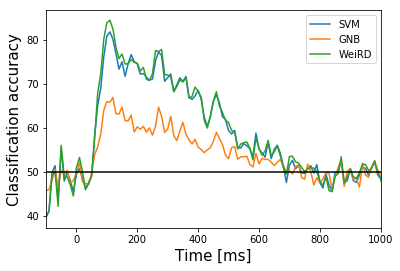

In [22]:
plt.plot(np.arange(-100, 1200, 10), 100*np.nanmean(data['svm'], axis=(0, 1, 2))+50, label='SVM')
plt.plot(np.arange(-100, 1200, 10), 100*np.nanmean(data['gnb'], axis=(0, 1, 2))+50, label='GNB')
plt.plot(np.arange(-100, 1200, 10), 100*np.nanmean(data['weird'], axis=(0, 1, 2))+50, label='WeiRD')
# plt.plot(np.arange(-100, 1200, 10), 100*np.nanmean(data['lda'], axis=(0, 1, 2))+50, label='LDA')
plt.plot([-100, 1000], [50, 50], 'k-')
plt.xlim((-100, 1000))
plt.xlabel('Time [ms]', fontsize=15)
plt.ylabel('Classification accuracy', fontsize=15)
plt.legend()

Already for one participant and a reduced data set (10 insteada of 92 conditions), these results look like canonical decoding time courses. Note that the period -100ms to 0ms is the baseline phase and stimulus onset is at 0ms. In this example, Support Vector Machine and WeiRD outperform Gaussian Naive Bayes.